In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import datetime
import itertools

import sklearn
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc, roc_auc_score, average_precision_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import catboost
from catboost import *
import os
import random
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.svm import SVR

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% ! important; }<style>"))

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed = 911
seed_everything(seed)

In [31]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from abc import ABC, abstractmethod
from typing import List
from scipy.stats import norm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, FuncFormatter
import seaborn as sns
from collections import Counter
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
import datetime
import sys
import os
import tqdm

from typing import Tuple

# ML modeling

In [2]:
df = pd.read_csv('./ts_project/ts_project_data.csv')

key = df[['Key']]

y = df['Balance']
X = df.drop(['Balance', 'Date', 'Key', 'year', 'month', 'day'], axis=1)
date = df[['Date']]
key = df[['Key']]

# Оставляем отложенную выборку
X_train_test, X_out_of_time, y_train_test, y_out_of_time = X[:-150], X[-150:], y[:-150], y[-150:]
date_train_test, date_out_of_time = date[:-150], date[-150:]
key_train_test, key_out_of_time = key[:-150], key[-150:]

# Делаем стандартизацию
scaler = StandardScaler()
X_train_test_scaled = scaler.fit_transform(X_train_test)
X_out_of_time_scaled = scaler.transform(X_out_of_time)

# Разбиваем данные на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X_train_test_scaled, y_train_test, test_size=0.2, random_state=911)
date_train, date_test = train_test_split(date_train_test, test_size=0.2, random_state=911)
key_train, key_test = train_test_split(key_train_test, test_size=0.2, random_state=911)

# Добавляем столбец 'Key' обратно в X_train после всех преобразований:
X_train = np.hstack((X_train, key_train.values.reshape(-1, 1)))

## Feature selection

In [3]:
model = CatBoostRegressor(loss_function='RMSE', iterations=100, logging_level='Silent', random_seed=911)

### Filter method

In [4]:
# экземпляр класса SelectKBest, что выбирает 50 наилучших признаков на основе F-значений
# В данном случае, скоринговая функция - это F-score для регрессии, который рассчитывает F-value между признаком и целевой переменной
select = SelectKBest(score_func=f_regression, k=50)

# Применение выбора признаков к обучающим и тестовым данным
z = select.fit(X_train_test, y_train_test)

# DataFrame с p-значениями f_regression теста для каждого признака
p = pd.DataFrame(z.pvalues_)

# Получение маски для выбранных признаков
feat_mask=z.get_support(True)

# Извлечение имен выбранных признаков
selected_features = X_train_test.columns[feat_mask]
feat_filtered = selected_features

# Обучение модели используя только выбранные признаки
model.fit(X_train_test[feat_filtered], y_train_test) 

# Предсказание значений для данных, которые не были частью обучающего или тестового набора, используя только выбранные признаки
pred = model.predict(X_out_of_time[feat_filtered])

# Вычисление стандартного отклонения предсказанных значений и вывод его, округлённого до 2 знаков после запятой
std = np.std(pred).round(2)
print(f"Стабильность по Filtered method: {std} ")

Стабильность по Filtered method: 0.29 


### Wrapper method

In [5]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=50, step=1)

selector = selector.fit(X_train_test, y_train_test)
selector = selector.get_support(True)
selected_features = X_train_test.columns[selector]
feat_rfe = selected_features

model.fit(X_train_test[feat_rfe], y_train_test) 
pred = model.predict(X_out_of_time[feat_rfe])

std = np.std(pred).round(2)
print(f"Стабильность по Wrapper method: {std} ")

Стабильность по Wrapper method: 0.31 


### Embedded method

In [6]:
sfs = SequentialFeatureSelector(model, k_features=50, forward=True, floating=False, cv=TimeSeriesSplit(3), n_jobs=-1)
sfs.fit(X_train_test, y_train_test)

selected_features_mask = sfs.get_support()
sfs_features = X_train_test.columns[selected_features_mask]

model.fit(X_train_test[sfs_features], y_train_test) 
pred = model.predict(X_out_of_time)
std = np.std(pred).round(2)
print(f"Стабильность Embedded method: {std} ")

Стабильность Embedded method: 0.35 


#### Лучший фиче селектор - Filter method

## Подбор гиперпараметров и выбор модели

In [18]:
y = df['Balance']
X = df[feat_filtered]
date = df[['Date']]
key = df[['Key']]

# Оставляем отложенную выборку
X_train_test, X_out_of_time, y_train_test, y_out_of_time = X[:-150], X[-150:], y[:-150], y[-150:]
date_train_test, date_out_of_time = date[:-150], date[-150:]
key_train_test, key_out_of_time = key[:-150], key[-150:]

# Делаем стандартизацию
scaler = StandardScaler()
X_train_test_scaled = scaler.fit_transform(X_train_test)
X_out_of_time_scaled = scaler.transform(X_out_of_time)

# Разбиваем данные на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X_train_test_scaled, y_train_test, test_size=0.2, random_state=911)
date_train, date_test = train_test_split(date_train_test, test_size=0.2, random_state=911)
key_train, key_test = train_test_split(key_train_test, test_size=0.2, random_state=911)

# Добавляем столбец 'Key' обратно в X_train после всех преобразований:
X_train = np.hstack((X_train, key_train.values.reshape(-1, 1)))
X_test = np.hstack((X_test, key_test.values.reshape(-1, 1)))
X_out_of_time = np.hstack((X_out_of_time, key_out_of_time.values.reshape(-1, 1)))

In [11]:
def custom_metric(target_col, pred_col, key):
    results = []
    for target, pred, k in zip(target_col, pred_col, key):
        if target >= pred:
            result = abs(target - pred) * 0.014
        else:
            result = abs(target - pred) * (k + 0.01)
        results.append(result)
    return -np.mean(results) 

key_values = X_train[:, -1] # здесь лежит столбец Key
custom_scorer = make_scorer(custom_metric, greater_is_better=False, needs_proba=False, needs_threshold=False, key=key_values)  # Поскольку используется neg_mean_absolute_error, устанавливаем greater_is_better=False
kfold_cv = KFold(n_splits=3)

In [12]:
# Создадим pipeline
gbr_pipe = Pipeline([('gbr', GradientBoostingRegressor(random_state=911, loss='huber'))])

# Зададим параметры для перебора в GridSearch
params_gbr = {
    'gbr__learning_rate': [0.01, 0.005, 0.02],
    'gbr__n_estimators': [500, 700, 1000],
    'gbr__subsample': [0.5, 0.7, 1],
    'gbr__max_depth': [3, 5, 7, 9],
    'gbr__max_features': ['auto'],
}

# Создаем GridSearchCV
grid_gbr = GridSearchCV(gbr_pipe, params_gbr, cv=kfold_cv, scoring=custom_scorer, verbose=1, n_jobs=-1)

# Проводим поиск гиперпараметров
grid_gbr.fit(X_train, y_train)

print('Используемые гиперпараметры для Gradient Boosting Regressor:', grid_gbr.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Используемые гиперпараметры для Gradient Boosting Regressor: {'gbr__learning_rate': 0.005, 'gbr__max_depth': 5, 'gbr__max_features': 'auto', 'gbr__n_estimators': 500, 'gbr__subsample': 0.7}


In [13]:
# Создаем pipeline
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=911))])

# Задаем параметры для перебора в GridSearch
params_rf = {
    'rf__n_estimators': [500, 700, 1000],
    'rf__max_depth': [3, 5, 7],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [2, 5, 10],
    'rf__max_features': ['auto'],
}

# Создаем GridSearchCV
grid_rf = GridSearchCV(rf_pipe, params_rf, cv=kfold_cv, scoring=custom_scorer, verbose=1, n_jobs=-1)

# Проводим поиск гиперпараметров
grid_rf.fit(X_train, y_train)

print('Используемые гиперпараметры для Random Forest Regressor:', grid_rf.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Используемые гиперпараметры для Random Forest Regressor: {'rf__max_depth': 3, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}


In [16]:
# Создаем pipeline
cb_pipe = Pipeline([('cb', CatBoostRegressor(random_state=911, verbose=False))])

# Задаем параметры для перебора в GridSearch
params_cb = {
    'cb__iterations': [500, 700, 1000],
    'cb__learning_rate': [0.01, 0.005, 0.02],
    'cb__depth': [3, 5, 7],
    'cb__l2_leaf_reg': [1, 3, 5],
}

# Создаем GridSearchCV
grid_cb = GridSearchCV(cb_pipe, params_cb, cv=kfold_cv, scoring=custom_scorer, verbose=1, n_jobs=-1)

# Проводим поиск гиперпараметров
grid_cb.fit(X_train, y_train)

print('Используемые гиперпараметры для CatBoost Regressor:', grid_cb.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Используемые гиперпараметры для CatBoost Regressor: {'cb__depth': 5, 'cb__iterations': 700, 'cb__l2_leaf_reg': 3, 'cb__learning_rate': 0.005}


In [25]:
models = [grid_gbr, grid_rf, grid_cb]
model_names = ['Gradient Boosting Regressor', 'Random Forest Regressor', 'CatBoost Regressor']

results_list = []

for model, name in zip(models, model_names):
    preds = model.best_estimator_.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    custom = -custom_metric(y_test, preds, key_out_of_time)
    
    results_list.append([name, mae, mse, custom])
    

results = pd.DataFrame(results_list, columns=['Model', 'MAE', 'MSE', 'Custom metric'])
results

,Model,MAE,MSE,Custom metric
0,Gradient Boosting Regressor,0.10,0.03,0.00
1,Random Forest Regressor,0.13,0.04,0.00
2,CatBoost Regressor,0.12,0.04,0.00


#### Выбираем градиентный бустинг.

## Разладки

In [27]:
class CusumDetection():
    def __init__(self, threshold=1, alpha=0.01, beta=0.01, mean_diff=-0.3):
        super().__init__()
        self.mean_sum = None
        self.var_sum = None
        self.mean_estimate = 0
        self.var_estimate = 1
        self.alpha = alpha
        self.beta = beta
        self.mean_diff = mean_diff
        self.threshold = threshold
        self.stat = 0
        self.anoms = []
        self.stat_history = []

    def update(self, new_value):
        if self.mean_sum:
            # Отклонения среднего
            self.mean_estimate = self.mean_sum / self.mean_weights_sum
            self.mean_sum = (1 - self.alpha) * self.mean_sum + new_value
            self.mean_weights_sum = (1 - self.alpha) * self.mean_weights_sum + 1.0

            # Отклонения дисперсии
            self.var_estimate = self.var_sum / self.var_weights_sum
            self.normalized_value = (new_value - self.mean_estimate) / np.sqrt(self.var_estimate)
            self.var_sum = (1 - self.beta) * self.var_sum + (self.normalized_value - self.mean_estimate)**2
            self.var_weights_sum = (1 - self.beta) * self.var_weights_sum + 1.0

        # Если это первое значение
        else:
            self.mean_sum = new_value
            self.mean_weights_sum = 1.0
            self.normalized_value = (new_value - self.mean_estimate) / np.sqrt(self.var_estimate)
            self.var_sum = (self.normalized_value - self.mean_estimate)**2
            self.var_weights_sum = 1.0

        zeta_k = np.log(norm.pdf(self.normalized_value, self.mean_diff, 1) / norm.pdf(self.normalized_value, 0., 1))
        self.stat = max(0, self.stat + zeta_k)

    def check(self, new_value):
        self.update(new_value)
        self.stat_history.append(self.stat)
        if self.stat > self.threshold:
            self.anoms.append(1)
        else: self.anoms.append(0)

    def load_old(self, data):
        for i in data:
            self.update(i)

    def find_all(self, data):
        for i in data:
            self.check(i)
        return self.anoms

    def cleaning(self):
        self.mean_estimate = 0
        self.var_estimate = 1
        self.mean_sum = None
        self.var_sum = None
        self.stat = 0
        self.anoms = []
        self.stat_history = []

    def hist(self):
        return self.stat_history

In [28]:
# Так как мы переобучаемся каждый день, то нам нет смысла рефитаться при появлении разладки
# У нас не будет новых данных для рефита модели, так что придется просто переходить в ручной режим

def check_model (y_train, y_test_pred, a=0.2, b=0.2, mean_diff=0.3, threshold=1, graphics=False):
    detector = CusumDetection(threshold=threshold, alpha=a, beta=b, mean_diff = mean_diff)
    detector.load_old(y_train)
    razl_test_pol = detector.find_all(y_test_pred)
    if graphics == True:
        plt.plot(detector.hist(), label = 'Положительные отклонения')
    detector.cleaning()

    detector = CusumDetection(threshold=threshold, alpha=a, beta=b, mean_diff = - mean_diff)
    detector.load_old(y_train)
    razl_test_neg = detector.find_all(y_test_pred)
    if graphics == True:
        plt.plot(detector.hist(), label = 'Отрицательные отклонения')
        plt.xlabel('Время')
        plt.ylabel('Значения статистики')
        plt.legend()
        plt.show

    detector.cleaning()

    try:
        index_razl_pol = razl_test_pol.index(1)
    except: index_razl_pol = len(y_train) + 100
    try:
        index_razl_neg = razl_test_neg.index(1)
    except: index_razl_neg = len(y_train) + 100

    try:
        index_razl = min(index_razl_pol, index_razl_neg)
        if index_razl == len(y_train) + 100:
            raise ValueError
        print('Первая разладка через:', index_razl)
        print('Переходим в ручной режим')
        return index_razl
    except ValueError:
        print('Разладка не найдена')

Проверим, что моя функция *работает*

alpha и beta выставлю так, чтобы на старые веса из трейна оставалось 75% веса

Первая разладка через: 62
Переходим в ручной режим


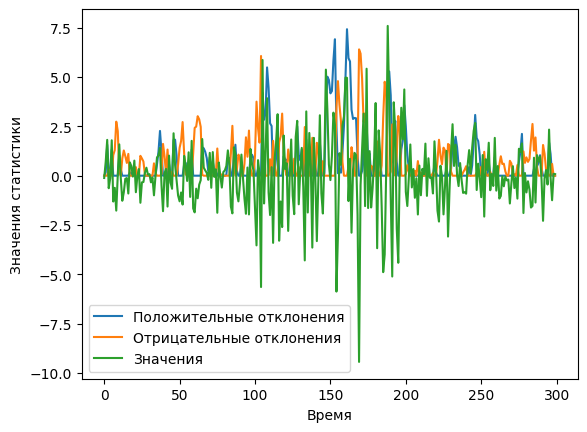

In [32]:
# Рост дисперсии

train = pd.Series(np.random.normal(loc=0, scale=1, size=300))
test =  pd.Series(np.hstack((
    np.random.normal(loc=0, scale=1, size=100),
    np.random.normal(loc=0, scale=3, size=100),
    np.random.normal(loc=0, scale=1, size=100),
)))

check_model(pd.Series(train), pd.Series(test), .02, .02, mean_diff = 1, threshold = 3, graphics = True)

plt.plot(test, label = 'Значения')
plt.legend()

Первая разладка через: 43
Переходим в ручной режим


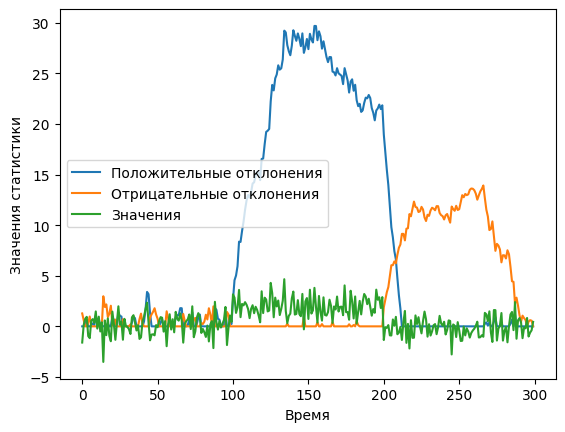

In [33]:
# Отклонения среднего

train = pd.Series(np.random.normal(loc=0, scale=1, size=300))
test =  pd.Series(np.hstack((
    np.random.normal(loc=0, scale=1, size=100),
    np.random.normal(loc=2, scale=1, size=100),
    np.random.normal(loc=0, scale=1, size=100),
)))

check_model(pd.Series(train), pd.Series(test), .02, .02, mean_diff = 1, threshold = 3, graphics = True)

plt.plot(test, label = 'Значения')
plt.legend()

А теперь на боевом датасете

Первая разладка через: 10
Переходим в ручной режим


10

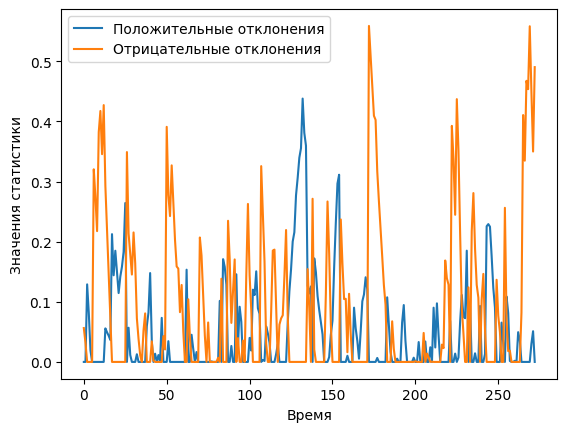

In [37]:
perfect_treshold = .4
perfect_mean_diff = y_train.std()
y_test_pred = grid_gbr.best_estimator_.predict(X_test)

check_model(y_train, y_test_pred, .1, .1, mean_diff = perfect_mean_diff, threshold=perfect_treshold, graphics = True)

In [46]:
y = df['Balance']
X = df[feat_filtered]
date = df[['Date']]
key = df[['Key']]

# Оставляем отложенную выборку
X_train_test, X_out_of_time, y_train_test, y_out_of_time = X[:-150], X[-150:], y[:-150], y[-150:]
date_train_test, date_out_of_time = date[:-150], date[-150:]
key_train_test, key_out_of_time = key[:-150], key[-150:]

In [ ]:
y = df['Balance']
X = df[feat_filtered]
date = df[['Date']]
key = df[['Key']]

# Оставляем отложенную выборку
X_train_test, X_out_of_time, y_train_test, y_out_of_time = X[:-150], X[-150:], y[:-150], y[-150:]
date_train_test, date_out_of_time = date[:-150], date[-150:]
key_train_test, key_out_of_time = key[:-150], key[-150:]

# Делаем стандартизацию
scaler = StandardScaler()
X_train_test_scaled = scaler.fit_transform(X_train_test)
X_out_of_time_scaled = scaler.transform(X_out_of_time)

# Разбиваем данные на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X_train_test_scaled, y_train_test, test_size=0.2, random_state=911)
date_train, date_test = train_test_split(date_train_test, test_size=0.2, random_state=911)
key_train, key_test = train_test_split(key_train_test, test_size=0.2, random_state=911)

# Добавляем столбец 'Key' обратно в X_train после всех преобразований:
X_train = np.hstack((X_train, key_train.values.reshape(-1, 1)))
X_test = np.hstack((X_test, key_test.values.reshape(-1, 1)))
X_out_of_time = np.hstack((X_out_of_time, key_out_of_time.values.reshape(-1, 1)))

In [48]:
date_out_of_time

,Date
1363,2020-11-02
1364,2020-11-03
1365,2020-11-04
1366,2020-11-05
1367,2020-11-06
...,...
1508,2021-03-27
1509,2021-03-28
1510,2021-03-29
1511,2021-03-30


In [ ]:
# Шаг 1: Получить лучшие параметры
best_params = grid_gbr.best_params_

# Шаг 2: Создать новый экземпляр модели с лучшими параметрами
model = GradientBoostingRegressor(**best_params)

# Шаг 3: Обучить модель на тренировочных данных.
model.fit(X_train_test, y_train_test)

# Шаг 4: Сделать предсказания на тестовых данных.
predictions = model.predict(X_test)

In [58]:
print(date_out_of_time.iloc[i][0])

2020-11-04


In [64]:
X_out_of_time_refit.iloc[i: i+148]

,Outcome,Key_lag1,Key_lag2,Key_lag3,Key_lag4,Key_lag5,Key_lag6,Key_mean,Key_median,Key_max,Key_min,Gold,Gold_lag1,Gold_lag2,Gold_lag3,Gold_lag4,Gold_lag5,Gold_lag7,Gold_lag14,Gold_lag21,Gold_lag30,Gold_mean,Gold_median,Gold_max,Gold_min,usd_rub_course,usd_rub_course_lag1,usd_rub_course_lag2,usd_rub_course_lag3,usd_rub_course_lag4,usd_rub_course_lag5,usd_rub_course_lag7,usd_rub_course_lag14,usd_rub_course_lag21,usd_rub_course_lag30,usd_rub_course_mean,usd_rub_course_median,usd_rub_course_max,usd_rub_course_min,YoY_deflator_GDP,MA7,MA30,Balance_mean,Balance_median,Target_lag1,Target_lag7,Target_lag14,Target_lag21,пн,чт
1369,0.00,4.25,4.25,4.25,4.50,5.50,5.50,4.25,4.25,4.25,4.25,4834.96,4886.56,4887.70,4784.40,4784.40,4759.17,4667.69,4785.15,4736.09,4770.62,4809.53,4784.40,4887.70,4729.52,76.89,76.89,77.56,79.05,80.52,79.47,78.84,76.54,77.92,78.08,78.70,79.05,80.52,76.89,105.39,-0.14,-0.21,-0.14,-0.01,0.00,0.00,0.00,0.00,0,0
1370,2.28,4.25,4.25,4.25,4.50,5.50,5.50,4.25,4.25,4.25,4.25,4834.10,4834.96,4886.56,4887.70,4784.40,4784.40,4729.52,4767.05,4754.14,4709.54,4824.47,4834.10,4887.70,4759.17,76.89,76.89,76.89,77.56,79.05,80.52,78.84,76.54,77.92,77.28,78.70,79.05,80.52,76.89,105.39,-0.07,-0.22,-0.14,-0.01,0.00,-0.83,-0.88,-0.44,1,0
1371,2.15,4.25,4.25,4.25,4.50,5.50,5.50,4.25,4.25,4.25,4.25,4834.10,4834.10,4834.96,4886.56,4887.70,4784.40,4759.17,4752.55,4772.77,4786.39,4835.17,4834.10,4887.70,4784.40,77.32,76.89,76.89,76.89,77.56,79.05,79.47,76.17,77.52,77.28,78.70,79.05,80.52,76.89,105.39,-0.09,-0.23,-0.07,-0.01,-0.33,-0.09,-0.29,-0.20,0,0
1372,1.70,4.25,4.25,4.25,4.50,5.50,5.50,4.25,4.25,4.25,4.25,4842.82,4834.10,4834.10,4834.96,4886.56,4887.70,4784.40,4750.35,4711.68,4786.39,4843.52,4834.96,4887.70,4784.40,76.26,77.32,76.89,76.89,76.89,77.56,80.52,76.45,77.59,77.28,78.70,79.05,80.52,76.89,105.39,-0.08,-0.22,-0.09,-0.01,-0.24,0.00,-0.66,-0.28,0,0
1373,2.21,4.25,4.25,4.25,4.50,5.50,5.50,4.25,4.25,4.25,4.25,4605.21,4842.82,4834.10,4834.10,4834.96,4886.56,4784.40,4697.13,4740.64,4771.68,4817.92,4834.96,4887.70,4605.21,76.46,76.26,77.32,76.89,76.89,76.89,79.05,77.29,77.28,76.84,78.70,79.05,80.52,76.89,105.39,-0.08,-0.22,-0.08,-0.01,0.08,-0.06,-0.56,-0.41,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,0.00,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4234.90,4245.63,4213.91,4157.94,4140.83,4140.83,4082.32,4065.79,4224.26,4296.61,4177.24,4157.94,4245.63,4106.63,76.12,76.62,76.33,74.80,74.15,74.32,74.32,73.30,74.56,74.07,75.60,76.12,76.62,74.15,111.95,-0.67,-0.38,-0.67,-0.59,-2.51,0.00,0.00,0.00,0,0
1509,0.00,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4234.90,4245.63,4213.91,4157.94,4140.83,4140.83,4082.32,4065.79,4224.26,4296.61,4177.24,4157.94,4245.63,4106.63,76.12,76.12,76.62,76.33,74.80,74.15,74.32,73.30,74.56,73.49,75.60,76.12,76.62,74.15,111.95,-0.67,-0.36,-0.67,-0.59,0.00,0.00,0.00,0.00,0,0
1510,3.37,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4208.46,4234.90,4245.63,4213.91,4157.94,4140.83,4106.63,4074.08,4158.78,4242.54,4191.79,4208.46,4245.63,4140.83,76.12,76.12,76.12,76.62,76.33,74.80,74.32,73.30,74.56,74.71,75.60,76.12,76.62,74.15,111.95,-0.70,-0.40,-0.67,-0.59,0.00,-0.81,-0.62,-0.00,1,0
1511,2.57,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4.25,4208.46,4208.46,4234.90,4245.63,4213.91,4157.94,4140.83,4103.11,4144.35,4228.69,4201.45,4208.46,4245.63,4140.83,75.66,76.12,76.12,76.12,76.62,76.33,74.15,73.32,74.33,74.71,75.60,76.12,76.62,74.15,111.95,-0.75,-0.41,-0.70,-0.59,-1.02,0.10,-0.51,-1.26,0,0


In [61]:
best_params = {key.replace('gbr__', ''): value for key, value in grid_gbr.best_params_.items()}
model = GradientBoostingRegressor(**best_params)

X_train_test_refit = X_train_test
y_train_test_refit = y_train_test
X_out_of_time_refit = X_out_of_time
y_out_of_time_refit = y_out_of_time

for i in range(X_out_of_time_refit.shape[0]):
    print(f'Дата: {date_out_of_time.iloc[i][0]}')
    model.fit(X_train_test_refit, y_train_test_refit)
    next_14_days_data = X_out_of_time_refit.iloc[i: i+14]
    predictions = model.predict(next_14_days_data)
    check_model(y_train_test_refit, predictions, .05, .05, mean_diff=0.3, threshold=perfect_treshold, graphics=False)

    X_train_test_refit = pd.concat([X_train_test_refit, pd.DataFrame(X_out_of_time_refit.iloc[[i]])], axis=0).reset_index(drop=True)
    y_train_test_refit = pd.concat([pd.DataFrame(y_train_test_refit), pd.DataFrame(y_out_of_time_refit.iloc[[i]])], axis=0).reset_index(drop=True)
    y_train_test_refit = y_train_test_refit['Balance']

Дата: 2020-11-02
Первая разладка через: 0
Переходим в ручной режим
Дата: 2020-11-03
Первая разладка через: 0
Переходим в ручной режим
Дата: 2020-11-04
Первая разладка через: 0
Переходим в ручной режим
Дата: 2020-11-05
Первая разладка через: 0
Переходим в ручной режим
Дата: 2020-11-06
Первая разладка через: 0
Переходим в ручной режим
Дата: 2020-11-07
Первая разладка через: 19
Переходим в ручной режим
Дата: 2020-11-08


KeyboardInterrupt: 